# IPI Report

Exploring Municipial Dataset; the columns describe financial, crime and employment statistics for Idaho cities. However, some of the columns relate to measurements made at the county level.  

##### Importing libraries
> If local enviorment doe not contain a module then the syntax to download through jupyter is
<br><br>
`!conda install [package]` <br>
       or <br>
`!pip install [package]` <br>
<br>
Installation instructions may vary and the official docs should be referenced

In [1]:
import support.load_data as load
import support.supporting_funcs as funcs
import support.plotting_funcs as ipiplot

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LassoCV
from linearmodels.panel import PanelOLS
import sympy
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Load Dataset (Panel Data)

Using a function we created and store within the supporting folder, we will take the dataset and convert the financial values from nominal to real dollars. We use the CPI for 2019 but future analysis should adjust to the most recent CPI value to allow for full comprehension of a dollar. Structured as a panel this dataset contains information describing various cities from 1995 through 2014.    

In [2]:
df = load.all_data(norm=False)

Loading IPI data
Adjusting for Inflation
Getting GPS
Getting Employees
Merge Everything
Categorize City Size


## Visualize Panel

In [3]:
df = df.drop(columns= funcs.search_all(df, 'coun'))

County
County
FIPS_County
Counties - Assault- Total
Counties - Burglary- Total
Counties - Manslaughter- Total
Counties - Murder- Total
Counties - Rape-Total
Counties - Robbery- Total
Counties - Total- All Thefts
County FIPS Code
County/State
County FIPS Year
County Labor Force
County Labor Employed
County Labor Unemployed


Again we reference a supporting function which we use to search for and drop all columns representing county level data

In [4]:
df.shape

(1509, 615)

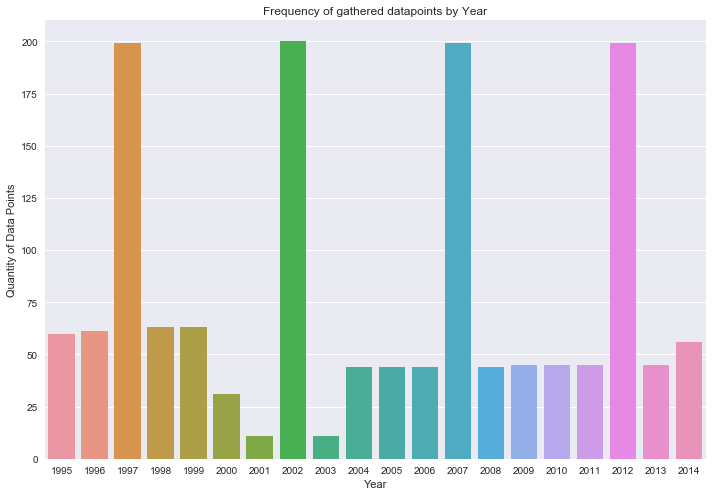

In [5]:
plt.style.use('seaborn')
sns.barplot(x='Year4', y='Population', data=df.groupby('Year4').count().reset_index())
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.ylabel('Quantity of Data Points')
plt.xlabel('Year')
plt.title('Frequency of gathered datapoints by Year')
plt.tight_layout()

In [6]:
df = df.loc[df['Year4'].isin([1997, 2002, 2007, 2012])]

This data set has a lot of missing values so we removed every year other than 1997, 2002, 2007 and 2012. This provides us measurements on the max number of features while also maintaining balance. Removing these years was necessisary to maintain high quality input data.  

## Dependant Variable 

The set contains many statistics desribing the financial activity of each city but only seven variables describing crime. These crime statsistics are unique measuements relative to the financial majority. There are a few other columns not describing finances, such as population, but we concluded that these columns would not provide the same value as identifying relations describing criminal activities. <br><br>

Distinct from crime we also had information on unemployment data. We were unable to address this within the time constraint but doing so would likely prove fruitful. 

In [7]:
df.shape

(797, 615)

In [8]:
cities = (df.groupby('Name')['Assault- Total - Municipalities'].count() == 4)
cities = cities[cities == True].index
df = df[df['Name'].isin(cities)]
df.shape

(236, 615)

Having already removed useless data on our minor axis (years) we then sought to do the same to our major axis (cities). Above we removed any city that did not have data for all four years, this reduced the total records in our dataframe from 1509 to 236. This unfortunately removed a large portion of the original set but greatly improved the overall quality of our scope.  

In [9]:
tmp = df.notna().sum()
tmp = tmp[tmp > 206]
df = df.loc[:,tmp.index]
df.shape

(236, 101)

Reducing our set an additional time we removed any feature that did not contain values for at least 87% of the total records. 

In [10]:
df = df.set_index(['Name', 'Year4'])

We are now done addressing missing data so we set the indices of our dataframe so that it will be recognized as a panel in future manipulations. 

In [11]:
df.drop(columns=['LAUS Code', 'latitude', 'longitude'],inplace=True)

The column LAUS Code is an object data type and contained little varience so we remnoved it from our set so that we didnt not have to waste time attempting to represent it as quantitative value. Additionally longitude contained negative values that could not be handled in futer models so we chose to remove it along with latitude.

In [12]:
dummies = pd.get_dummies(df['size'])
df.drop(columns=['size'],inplace=True)
df = pd.concat([df, dummies], axis=1)

Size is a catagorical variable and depicts the size of a city so we replaced it with three dummy variables representing its catagories. 

In [13]:
df = df.interpolate()

Finally we believe we have derived the optimal set to attempt to describe criminal activity. However there are still a few null values, so we leverage the panel structure and use interpolate to fill in these nulls. Calculating our own values for these nulls is potentially harmful but we minimzed damage done here because we already dropped features that did not contain values for at least 87% of total records.  

## Loop Start

Our analyses only addresses Total Thefts as our dependent but with minimal reworking one could construct a loop iterating through each crime statistic as the model's dependent variable. 

In [14]:
dep_var = 'Total- All Thefts - Municipalities'
y = df[dep_var]
y = y.rename(dep_var)
y = pd.DataFrame(y)
y = y.astype(int)

Here we save Total Thefts as a y variable

In [15]:
X = df.drop(columns = ['Robbery- Total - Municipalities',
       'Rape-Total - Municipalities',
       'Murder- Total - Municipalities', 
       'Total- All Thefts - Municipalities',
       'Manslaughter-Total - Municipalities',
       'Burglary-Total - Municipalities',
       'Assault- Total - Municipalities'])

Now dropping everyother crime variable from our data frame as to prevent them from causing undesired noise in our model.

## Lasso

Here we use Lasso to give an estimate for the value we should use for K in our next model.

In [16]:
reg = LassoCV(cv=3, tol=0.0009)
reg.fit(X, y[dep_var])
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))

Best alpha using built-in LassoCV: 65541.855905
Best score using built-in LassoCV: 0.952387


In [17]:
coef = pd.Series(reg.coef_, index = X.columns)
k_esi = sum(coef != 0)
print("Lasso picked " + str(k_esi) + " variables")

Lasso picked 24 variables


## SelectKBest

In [18]:
selector = SelectKBest(score_func=chi2, k=k_esi)
selector.fit(X, y)

SelectKBest(k=24, score_func=<function chi2 at 0x1c1ff80400>)

In [19]:
cols = selector.get_support(indices=True)

X_chi = X.iloc[:,cols]

## Split

In [20]:
reduced_form, inds = sympy.Matrix(X_chi.values).rref()
X_chi = X_chi.iloc[:, list(inds)]

In [21]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_chi.values, i) for i in range(X_chi.shape[1])]
vif["features"] = X_chi.columns

/Users/dom/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [22]:
indep_var = vif.iloc[vif['VIF Factor'].drop_duplicates().index]['features']

In [23]:
X_chi = X_chi.loc[:,indep_var]


In [24]:
train_X, val_X, train_y, val_y = train_test_split(X_chi, y, test_size=0.2)
# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

## Regression

In [25]:
reduced_form, inds = sympy.Matrix(train_X.values).rref()
train_X = train_X.iloc[:, list(inds)]

In [26]:
paneols = PanelOLS(df[dep_var],df[indep_var], time_effects=True)
res = paneols.fit()
res

Dep. Variable:,Total- All Thefts - Municipalities,R-squared:,0.9465
Estimator:,PanelOLS,R-squared (Between):,0.9776
No. Observations:,236,R-squared (Within):,-0.0686
Date:,"Sun, Jan 05 2020",R-squared (Overall):,0.9531
Time:,00:23:51,Log-likelihood,-1712.8
Cov. Estimator:,Unadjusted,,
,,F-statistic:,210.29
Entities:,59,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(18,214)"
Min Obs:,4.0000,,
Max Obs:,4.0000,F-statistic (robust):,210.29


In [27]:
pred_y_pane = res.predict(val_X)
r2_score(val_y, pred_y_pane)

0.858762557796094

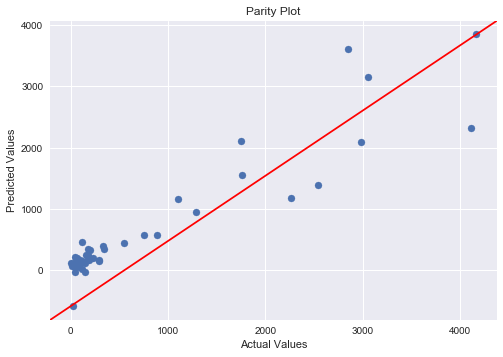

In [28]:
fig, ax = plt.subplots()

ax.scatter(x=val_y, y=pred_y_pane['predictions'])
line = mlines.Line2D([0,1], [0,1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_title('Parity Plot')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.show()

## Dep on Indep

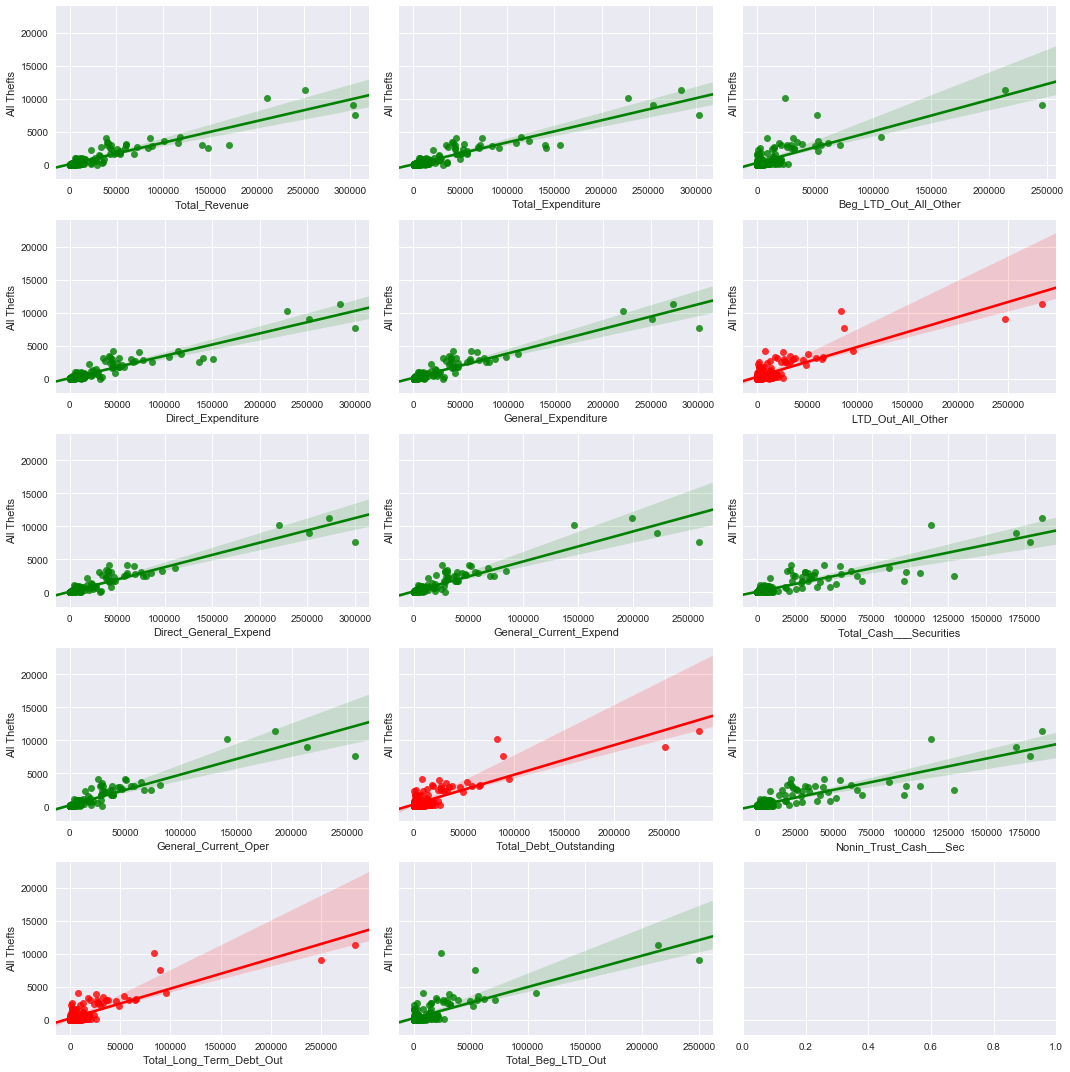

In [29]:
fig1, axs= plt.subplots(figsize=(15,15),nrows=5, ncols=3, sharey=True)
    

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Total_Revenue'], ax=axs[0,0], color='g')
axs[0, 0].set_xlabel("Total_Revenue")
axs[0, 0].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Total_Expenditure'], ax=axs[0,1], color='g')
axs[0, 1].set_xlabel("Total_Expenditure")
axs[0, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Beg_LTD_Out_All_Other'], ax=axs[0,2], color='g')
axs[0, 2].set_xlabel("Beg_LTD_Out_All_Other")
axs[0, 2].set_ylabel('All Thefts')

###############

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Direct_Expenditure'], ax=axs[1,0], color='g')
axs[1, 0].set_xlabel("Direct_Expenditure")
axs[1, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['General_Expenditure'], ax=axs[1,1], color='g')
axs[1, 1].set_xlabel("General_Expenditure")
axs[1, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['LTD_Out_All_Other'], ax=axs[1,2], color='r')
axs[1, 2].set_xlabel("LTD_Out_All_Other")
axs[1, 2].set_ylabel('All Thefts')
##################

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Direct_General_Expend'], ax=axs[2,0], color='g')
axs[2, 0].set_xlabel("Direct_General_Expend")
axs[2, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['General_Current_Expend'], ax=axs[2,1], color='g')
axs[2, 1].set_xlabel("General_Current_Expend")
axs[2, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Total_Cash___Securities'], ax=axs[2,2], color='g')
axs[2, 2].set_xlabel("Total_Cash___Securities")
axs[2, 2].set_ylabel('All Thefts')
###############

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['General_Current_Oper'], ax=axs[3,0], color='g')
axs[3, 0].set_xlabel("General_Current_Oper")
axs[3, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Total_Debt_Outstanding'], ax=axs[3,1], color='r')
axs[3, 1].set_xlabel("Total_Debt_Outstanding")
axs[3, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Nonin_Trust_Cash___Sec'], ax=axs[3,2], color='g')
axs[3, 2].set_xlabel("Nonin_Trust_Cash___Sec")
axs[3, 2].set_ylabel('All Thefts')
##################

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Total_Long_Term_Debt_Out'], ax=axs[4,0], color='r')
axs[4, 0].set_xlabel("Total_Long_Term_Debt_Out")
axs[4, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X_chi['Total_Beg_LTD_Out'], ax=axs[4,1], color='g')
axs[4, 1].set_xlabel("Total_Beg_LTD_Out")
axs[4, 1].set_ylabel('All Thefts')



plt.tight_layout()

## Bayes

In [30]:
clf = BayesianRidge(compute_score=True)
clf.fit(train_X, train_y)
pred_y_baye = clf.predict(val_X)

/Users/dom/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
r2_score(val_y, pred_y_baye)

0.8066579481479218

In [32]:
# np.sqrt(mean_squared_log_error(val_y, pred_y_baye))

## Random Forest

In [33]:
regr = RandomForestRegressor(n_estimators=100)
regr.fit(train_X, train_y)
pred_y_rand = regr.predict(val_X)

/Users/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [34]:
r2_score(val_y, pred_y_rand)

0.8394306570472858

In [35]:
np.sqrt(mean_squared_log_error(val_y, pred_y_rand))

0.8188288042296419

## Another Split

In [36]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

## GridSearchCV

In [37]:
X.columns.size//2

45

In [38]:
np.arange(2,X.columns.size)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90])

In [39]:
train_y.head()

,,Total- All Thefts - Municipalities
Name,Year4,
SUN VALLEY CITY,1997,2
PAYETTE CITY,2007,220
MONTPELIER CITY,1997,33
CHUBBUCK CITY,2007,968
OSBURN CITY,2007,23


In [40]:
tuned_params = [{'kbest__k':np.arange(5,X.columns.size//2, 5), 'rand__n_estimators':[5,10,50,100,500,1000]}]
model = SelectKBest(score_func=chi2, k=2)

pipeline = Pipeline([('kbest',model), ('rand', RandomForestRegressor(n_estimators=5))])

clf = GridSearchCV(estimator=pipeline, param_grid=tuned_params, cv=5, refit=True, scoring='neg_mean_squared_error')

clf.fit(train_X, train_y[dep_var])

/Users/dom/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=2, score_func=<function chi2 at 0x1c1ff80400>)), ('rand', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity...ators=5, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kbest__k': array([ 5, 10, 15, 20, 25, 30, 35, 40]), 'rand__n_estimators': [5, 10, 50, 100, 500, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [41]:
clf.best_params_

{'kbest__k': 5, 'rand__n_estimators': 10}

In [42]:
pred_y_grid = clf.predict(val_X)
r2_score(val_y, pred_y_grid)

0.25871323202698526

In [43]:
np.sqrt(mean_squared_log_error(val_y, pred_y_grid))

1.340130360060179